In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
# Загрузить стартовую страницу и подготовить файл для записи
driver = webdriver.Chrome()
ref = 'https://www.tripadvisor.com/Restaurants-g298484-Moscow_Central_Russia.html#MAINWRAP'
driver.get(ref)
filters = ['//*[@id="jfy_filter_bar_price"]/div[2]', '//*[@id="jfy_filter_bar_price"]/div[3]', '//*[@id="jfy_filter_bar_price"]/div[4]']
for f in filters:
    i = 0
    while not 'selected' in driver.find_element_by_xpath(f).get_attribute('class') or i > 10:
        driver.find_element_by_xpath(f).click()
        time.sleep(1)
        i += 1
source = driver.page_source
f = open('tripadvisor_restaurants.csv', 'w')
f.close()

In [109]:
# Функция выгружает рестораны с ненулевым количеством отзывов
    soup = bs(page, 'lxml')
    divs = soup.findAll('div', class_='shortSellDetails')
    # Удалим рестораны с пустыми отзывами - exception из-за разной двух вариантов структуры тэгов с нулевыми отзывами
    rests_with_reviews = []
    for div in divs:
        try:
            if div.find('span', class_='reviewCount').text!='Оставить первый отзыв об этом ресторане':
                rests_with_reviews.append(div)
        except:
            pass
    # Получим имя ресторана
    names = [div.find('h3', class_='title').text.strip('\n') for div in rests_with_reviews]
    print(len(names))
    # Получим средний чек
    checks = []
    for div in rests_with_reviews:
        try:
            check = div.find('span', class_='price').text
        except:
            check = '0'
        checks.append(check)
    checks_cleaned = [re.sub('[^0-9,-]', '', check) for check in checks]
    avg_check_final = [eval(check.replace('-', '+'))/2 if '-' in check else eval(check) for check in checks_cleaned]
    avg_check_final
    # Получим ссылки на отзывы
    hrefs_raw = [div.find('span', class_='reviewCount') for div in rests_with_reviews]
    hrefs = ['https://www.tripadvisor.ru' + i.a['href'] for i in hrefs_raw]
    # допишем в файл
    database = pd.DataFrame(data = list(zip(names, avg_check_final, hrefs)))
    with open(file, 'a') as f:
        database.to_csv(f, encoding='cp1251', header = False, index=False)

In [116]:
# Проходим по выданным фильтром страницам и собираем начальную информацию
page_num = 1
position = 30
last_page = int(driver.find_element_by_css_selector("#EATERY_LIST_CONTENTS > div.deckTools.btm > div > div > a:nth-child(8)").text)
print(last_page)
while page_num <= last_page:
    href = 'https://www.tripadvisor.ru/RestaurantSearch-g298484-oa'+ str(position) + '-p15-Moscow_Central_Russia.html#EATERY_LIST_CONTENTS'
    driver.get(href)
    source = driver.page_source
    download_rests_data(source, 'tripadvisor_restaurants.csv')
    print(page_num, "done")
    page_num += 1
    position += 30

39
30
1 done
30
2 done
30
3 done
30
4 done
30
5 done
30
6 done
30
7 done
30
8 done
30
9 done
30
10 done
30
11 done
30
12 done
30
13 done
30
14 done
30
15 done
30
16 done
30
17 done
30
18 done
30
19 done
30
20 done
30
21 done
30
22 done
30
23 done
30
24 done
30
25 done
30
26 done
30
27 done
30
28 done
30
29 done
30
30 done
30
31 done
30
32 done
30
33 done
20
34 done
0
35 done
0
36 done
0
37 done
0
38 done
30
39 done


In [5]:
# Открываем получившийся CSV в виде датафрейма, добавляем хэдеры
database = pd.read_csv('tripadvisor_restaurants.csv', header = None, names = ['Name', 'Avg check', 'Hrefs'], encoding = 'cp1251')
# Примечание: некоторые рестораны в списке повторялись по несколько раз, но отзывы в них не повторялись, поэтому я не стала фильтровать по имени

In [6]:
database[1:10]

Name  Avg check  \
1       I Like Wine     1493.0   
2             Савва     2521.5   
3     Кафе Сценарио      896.0   
4  Стейк Хаус Бизон     2754.0   
5            Бардак      531.0   
6           Венеция     1028.5   
7        Кафе Рулет     1260.5   
8  Ресторан Воронеж     1758.5   
9    Кафе Натахтари     1161.5   

                                               Hrefs  
1  https://www.tripadvisor.ru/Restaurant_Review-g...  
2  https://www.tripadvisor.ru/Restaurant_Review-g...  
3  https://www.tripadvisor.ru/Restaurant_Review-g...  
4  https://www.tripadvisor.ru/Restaurant_Review-g...  
5  https://www.tripadvisor.ru/Restaurant_Review-g...  
6  https://www.tripadvisor.ru/Restaurant_Review-g...  
7  https://www.tripadvisor.ru/Restaurant_Review-g...  
8  https://www.tripadvisor.ru/Restaurant_Review-g...  
9  https://www.tripadvisor.ru/Restaurant_Review-g...

In [10]:
def get_revs_data(page, lst):
    driver.get(page)
    try:
        last_page = int(driver.find_element_by_xpath(("//a[@class='pageNum taLnk' and contains(@onclick,'last')]")).text)
    except:
        last_page = 1
    months = {' января ':'01', ' февраля ':'02', ' марта ':'03', ' апреля ':'04', ' мая ':'05', ' июня ':'06', ' июля ':'07', ' августа ':'08',
            ' сентября ':'09', ' октября ':'10', ' ноября ':'11', ' декабря ':'12'}
    pattern = re.compile(r'\b(' +'|'.join(months.keys())+ r')\b')
    page_num = 1
    position = 10
    dates = []
    ratings = []
    while page_num <= last_page:
        if page_num == 1:
            rev_href = page
        else:
            rev_href = re.sub(r'^((.*?-.*?){2})-', r'\1-or%s-' %position, page)
            if page_num < last_page:
                position += 10
            driver.get(rev_href)
        rest_soup = bs(driver.page_source,'lxml')
        review_bubbles = rest_soup.findAll('div', class_='reviewItemInline')
        for bubble in review_bubbles:
                # Получим даты отзывов
            raw_date1 = bubble.find('span', class_='ratingDate')
                # Опытным путем было выяснено, что newlines внутри тэга мешают дальнейшей обработке и их пришлось удалить на этом этапе
                # Из-за неоднородной структуры страниц несколько исключений
            try:
                raw_date1.string.replace_with(raw_date1.string.strip())
            except:
                raw_date1.previousSibling.replace_with(raw_date1.previousSibling.strip())
            try:
                date = raw_date1['title']
            except:
                date = raw_date1.text.split(' ', 2)[-1]
            raw_date2 = pattern.sub(lambda x: months[x.group()], date)
                # В некоторых случаях strptime не парсит даты, например '3122013' возвращает ошибку out of range,в то же время '8122013' распознает
                # Способа нормально обойти это с помощью модифицирования функции не нашлось, поэтому пришлось сделать наивно:
            if len(raw_date2) == 7:
                raw_date2 = '0' + raw_date2
            date_fine = datetime.datetime.strptime(raw_date2, "%d%m%Y").date()
            dates.append(date_fine)
                # Собираем рейтинги
            rating = int(bubble.img['alt'].split(' ',1)[0])
            ratings.append(rating)
        print(page_num, ' done')
        page_num += 1
    stat = list(zip(dates, ratings))
    lst.append(stat)

In [130]:
# Для каждого ресторана заходим в href, проходимся по ссылкам и собираем дату и рейтинг для каждого отзыва
# Записываем даты и рейтинги в structured numpy array
# Добавляем в датафрейм column и помещаем туда массив для каждого ресторана
stats = []
for href in database['Hrefs']:
        name = database['Name'][database['Hrefs'] == href]
        print(name)
        get_revs_data(href, stats)
        print(name, 'DONE')
stats_as_arr = [np.array(stat, dtype=[('datetime64', object), ('x','f')]) for stat in stats]
np.save('stats_as_arr', stats_as_arr)

0    Корчма Тарас Бульба
Name: Name, dtype: object
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
12  done
13  done
14  done
15  done
16  done
17  done
18  done
19  done
20  done
21  done
22  done
23  done
24  done
25  done
26  done
27  done
28  done
0    Корчма Тарас Бульба
Name: Name, dtype: object DONE
1    I Like Wine
Name: Name, dtype: object
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
12  done
13  done
14  done
1    I Like Wine
Name: Name, dtype: object DONE
2    Савва
Name: Name, dtype: object
1  done
2  done
3  done
4  done
5  done
6  done
7  done
2    Савва
Name: Name, dtype: object DONE
3    Кафе Сценарио
Name: Name, dtype: object
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
3    Кафе Сценарио
Name: Name, dtype: object DONE
4    Стейк Хаус Бизон
Name: Name, dtype: object
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10

In [7]:
# Возникла проблема с сохранением формата numpy array при чтении датафрейма из файла, поэтому я сохранила данные как recarrays
# в бинарном формате в отдельный файл и затем подгружаю и прикрепляю его к датафрейму
stats = np.load('stats_as_arr.npy')
database['Stats'] = stats
database = database.drop('Hrefs', axis = 1)

In [8]:
# UPD Выяснилось, что удобнее работать со структурированными массивами, чтобы обращаться к колонкам по именам
stats_rec = []
for stat in database['Stats']:
    stat = stat.view(np.recarray)
    stat.sort(order = 'datetime64')
    stats_rec.append(stat)
database['Stats'] = stats_rec

In [9]:
database = database.sort_values(by=['Avg check'])
database

Name  Avg check  \
881                             Брюсофф        0.0   
493                        Кафе Veranda        0.0   
452                          Дэйли Кофе      165.5   
463                    Aromi la bottega      165.5   
466                             БухУчёт      165.5   
893                            Ватрушка      165.5   
456                          Koupes Bar      166.0   
164                              Пян-се      166.0   
764                     Caffe del Parco      199.0   
676                          Urban Cafe      199.0   
275                              Пян-се      199.0   
585                         ПитерБургер      199.0   
472                           Эль Асадо      199.0   
664                        Помидорка РП      199.0   
634                          ПАСТА ТАЙМ      232.0   
229                          Мистер Пит      232.0   
1008                             НаВоке      232.0   
821                 Траттория "БУОНИНИ"      232.0   
274                         Гриль&Гирос      232.5   
272                               Варка      232.5   
619   Coffee and the City на Бауманской      232.5   
678                 Coffee and the City      232.5   
597                    Джелатерия AMORE      232.5   
968                    Ресторан Санремо      232.5   
228                           Porosello      232.5   
48                           Калина Бар      265.0   
686                             Бризоль      265.0   
896                               Океан      265.0   
661                     Кафе Арифметика      265.5   
756                          Коммуналка      265.5   
...                                 ...        ...   
734                 Ресторан "От Кутюр"     4645.5   
13                       Brasserie Мост     4977.0   
74      Ресторан "Белое Солнце Пустыни"     4977.0   
213                        Храм Дракона     4977.0   
439                           Темпл Бар     4977.0   
31               Balzi Rossi Restaurant     4977.0   
523                  Караоке клуб Дуэты     4977.0   
578                  Октябрь Event Hall     4977.0   
128                 Ресторан "Павильон"     5640.5   
219                        Балчуг Гриль     5806.5   
950                           Cipollino     6171.5   
391                            Бельэтаж     6636.0   
338                              Фреско     6636.0   
37         Ресторан-бар "Консерватория"     7299.5   
131                            Оптимист     7764.5   
196                         Pane & Olio     7864.0   
530                             Буйабес     9124.5   
550                                Пеши     9523.0   
124                           Бар Крыша     9622.0   
431                           Royal Bar    10286.0   
598                          Тинто Фино    11613.0   
837                   Ресторан Fabrique    12442.5   
807                              Мисато    13272.0   
241               Greene King Pub&Roast    17917.5   
47                         Рыбный базар    18249.5   
181                                 Яръ    19908.5   
531                         Джаггер бар    25151.0   
29                           Экспедиция    36498.5   
369                            Jon Joli    72997.5   
824                            Симачярд   116132.5   

                                                  Stats  
881   [[2014-07-07, 5.0], [2014-09-30, 5.0], [2014-1...  
493   [[2014-07-22, 4.0], [2014-07-29, 5.0], [2014-0...  
452   [[2016-01-29, 5.0], [2016-02-03, 5.0], [2016-0...  
463   [[2013-08-26, 5.0], [2014-03-11, 5.0], [2014-0...  
466   [[2016-01-09, 5.0], [2016-03-02, 5.0], [2016-0...  
893   [[2016-01-29, 5.0], [2016-02-02, 5.0], [2016-0...  
456   [[2015-07-22, 5.0], [2015-09-07, 5.0], [2015-0...  
164   [[2015-03-15, 4.0], [2015-03-26, 4.0], [2015-0...  
764   [[2014-06-08, 5.0], [2014-07-25, 4.0], [2014-1...  
676                                 [[2015-10-05, 5.0]]  
275   [[2015-09-04, 5.0], [2015-09-22, 5.0], [20

In [10]:
# Были удалены аутлаеры
database = database.drop([824, 369, 881, 493, 29, 531], axis = 0)
database.reset_index(inplace = True, drop = True)

График даты первого отзыва на размер (текущего) чека:
------------------------------------------------
Можно визуально оценить зависимость даты первого отзыва от размера среднего чека ресторана. Идея в том, что дата первого отзыва приближает момент, когда ресторан был открыт / замечен посетителями. Соображения о сумме чека, указанные в начале, остаются в силе

In [11]:
database['1st revw date'] = pd.Series([database['Stats'][i][0].datetime64 for i in range(0, len(database.index))])

In [12]:
database[1:10]

Name  Avg check  \
1  Aromi la bottega      165.5   
2           БухУчёт      165.5   
3          Ватрушка      165.5   
4        Koupes Bar      166.0   
5            Пян-се      166.0   
6   Caffe del Parco      199.0   
7        Urban Cafe      199.0   
8            Пян-се      199.0   
9       ПитерБургер      199.0   

                                               Stats 1st revw date  
1  [[2013-08-26, 5.0], [2014-03-11, 5.0], [2014-0...    2013-08-26  
2  [[2016-01-09, 5.0], [2016-03-02, 5.0], [2016-0...    2016-01-09  
3  [[2016-01-29, 5.0], [2016-02-02, 5.0], [2016-0...    2016-01-29  
4  [[2015-07-22, 5.0], [2015-09-07, 5.0], [2015-0...    2015-07-22  
5  [[2015-03-15, 4.0], [2015-03-26, 4.0], [2015-0...    2015-03-15  
6  [[2014-06-08, 5.0], [2014-07-25, 4.0], [2014-1...    2014-06-08  
7                                [[2015-10-05, 5.0]]    2015-10-05  
8  [[2015-09-04, 5.0], [2015-09-22, 5.0], [2015-0...    2015-09-04  
9  [[2016-03-02, 5.0], [2016-03-11, 5.0], [2016-0...    2016-03-02

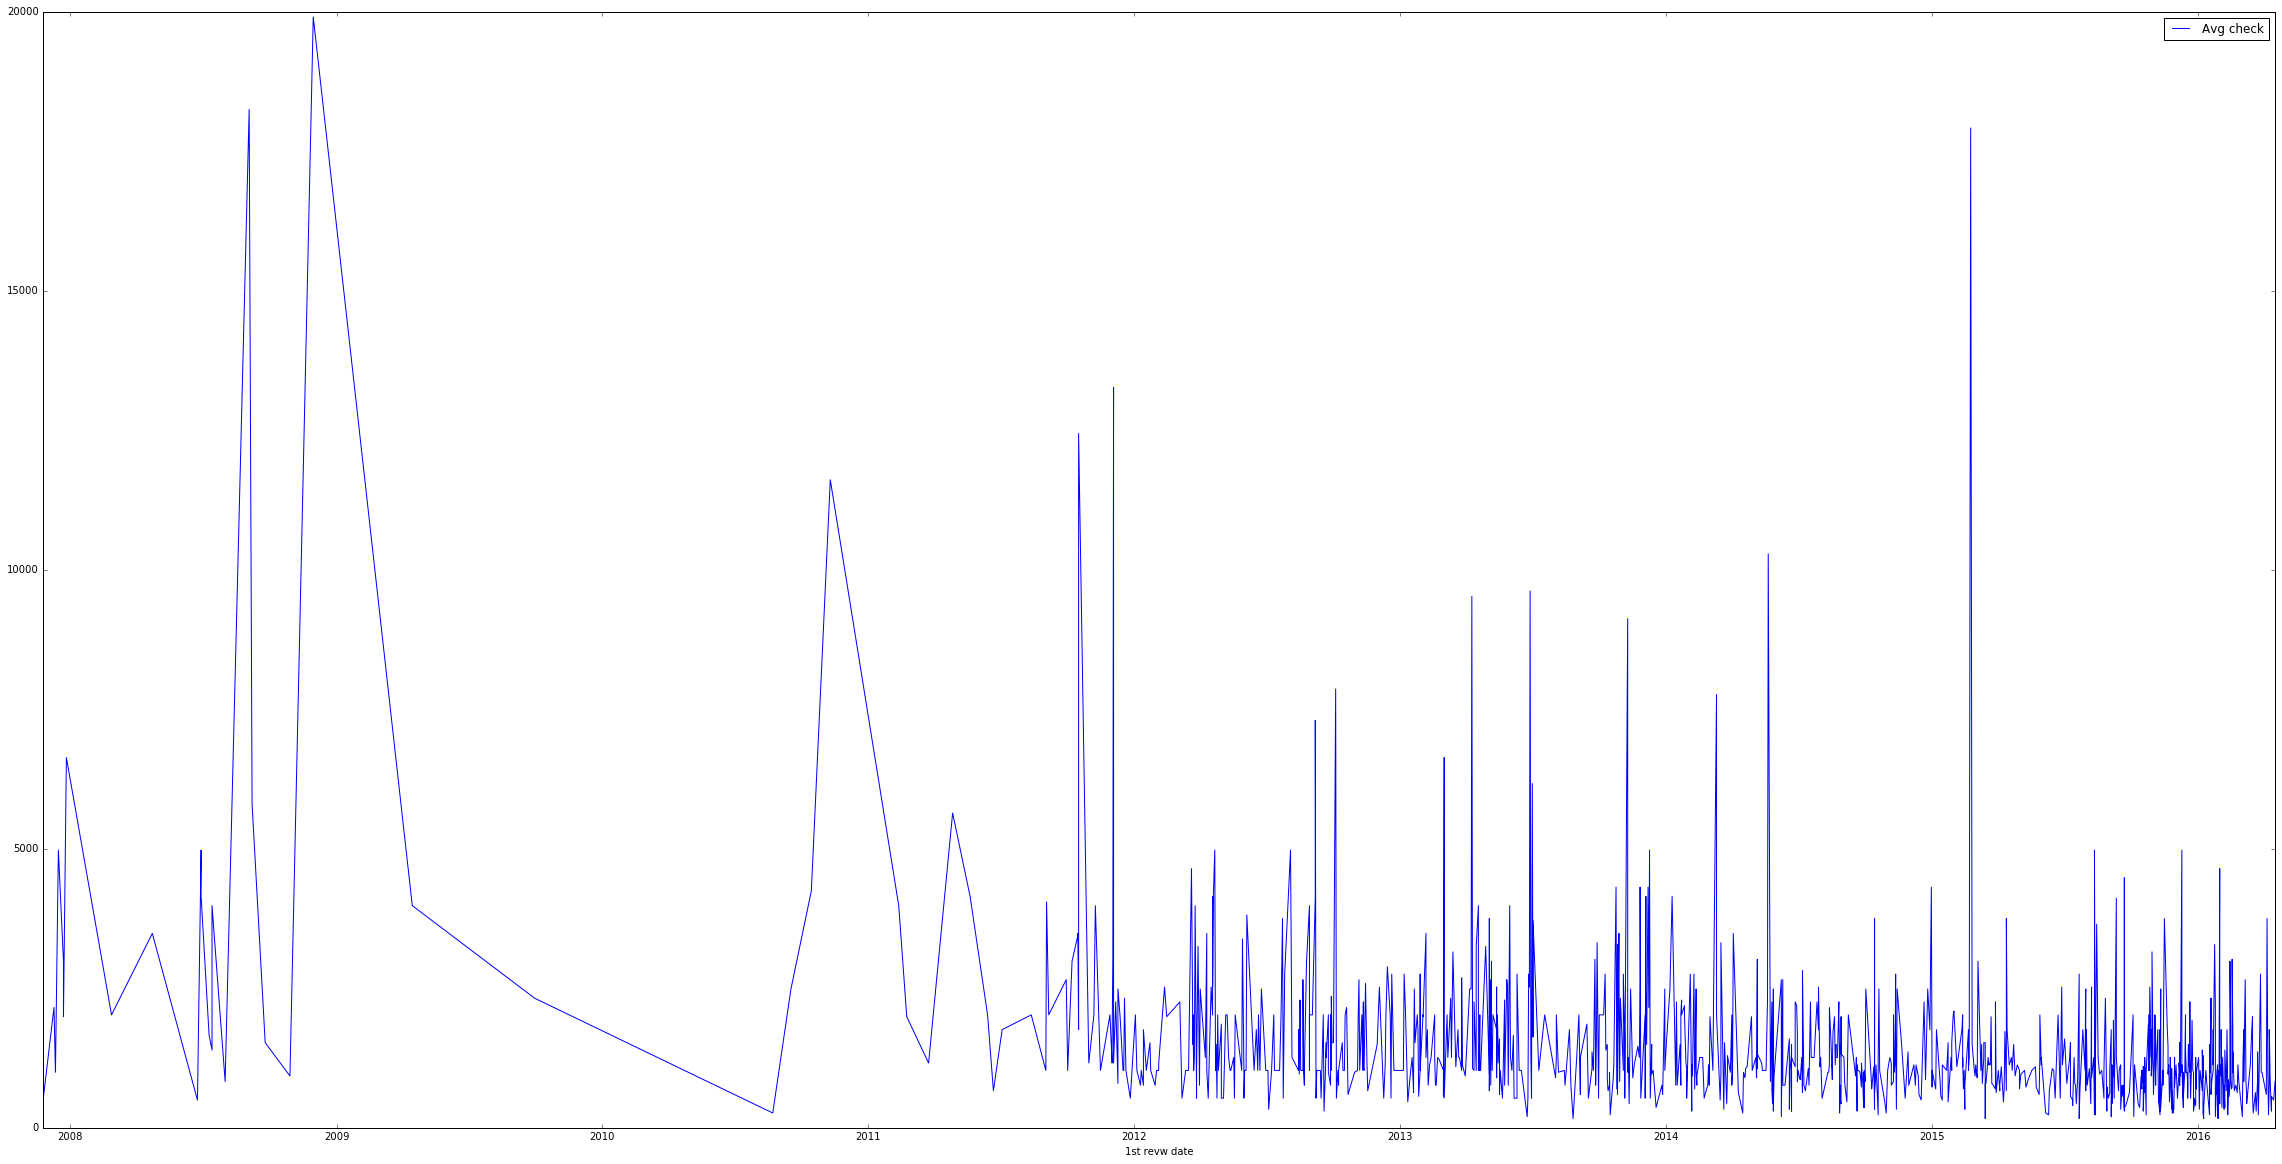

In [13]:
database.plot(x = '1st revw date',  y = 'Avg check', figsize = [40, 20])

Видно, что после 2015 г. был только один большой пик - первый отзыв на ресторан с размером чека более 15000 руб, также уменьшилось количество первых отзывов на рестораны с чеком в рамках 7000-15000.  Также можно заметить, что количество первых отзывов на рестораны с чеком <5000 руб увеличилось по сравнению с последними двумя годами (по более плотному заполнению пиками), но это может быть объяснено многими факторами, помимо возросшего внимания потребителей к недорогим ресторанам: например, возросшей популярностью самого ресурса tripadvisor.ru

В следующем графике была сделана попытка визуализировать частотное распределение всех отзывов в зависимости от среднего чека

In [366]:
lst = []
for i in range(0, len(database.index)):
    for j in range(0, database['Stats'][i].size):
        x = (database['Stats'][i][j].datetime64, database['Avg check'][i])
        lst.append(x)

In [367]:
date_check_arr = np.rec.array(lst, dtype=[('datetime64', 'O'), ('check', 'f')])

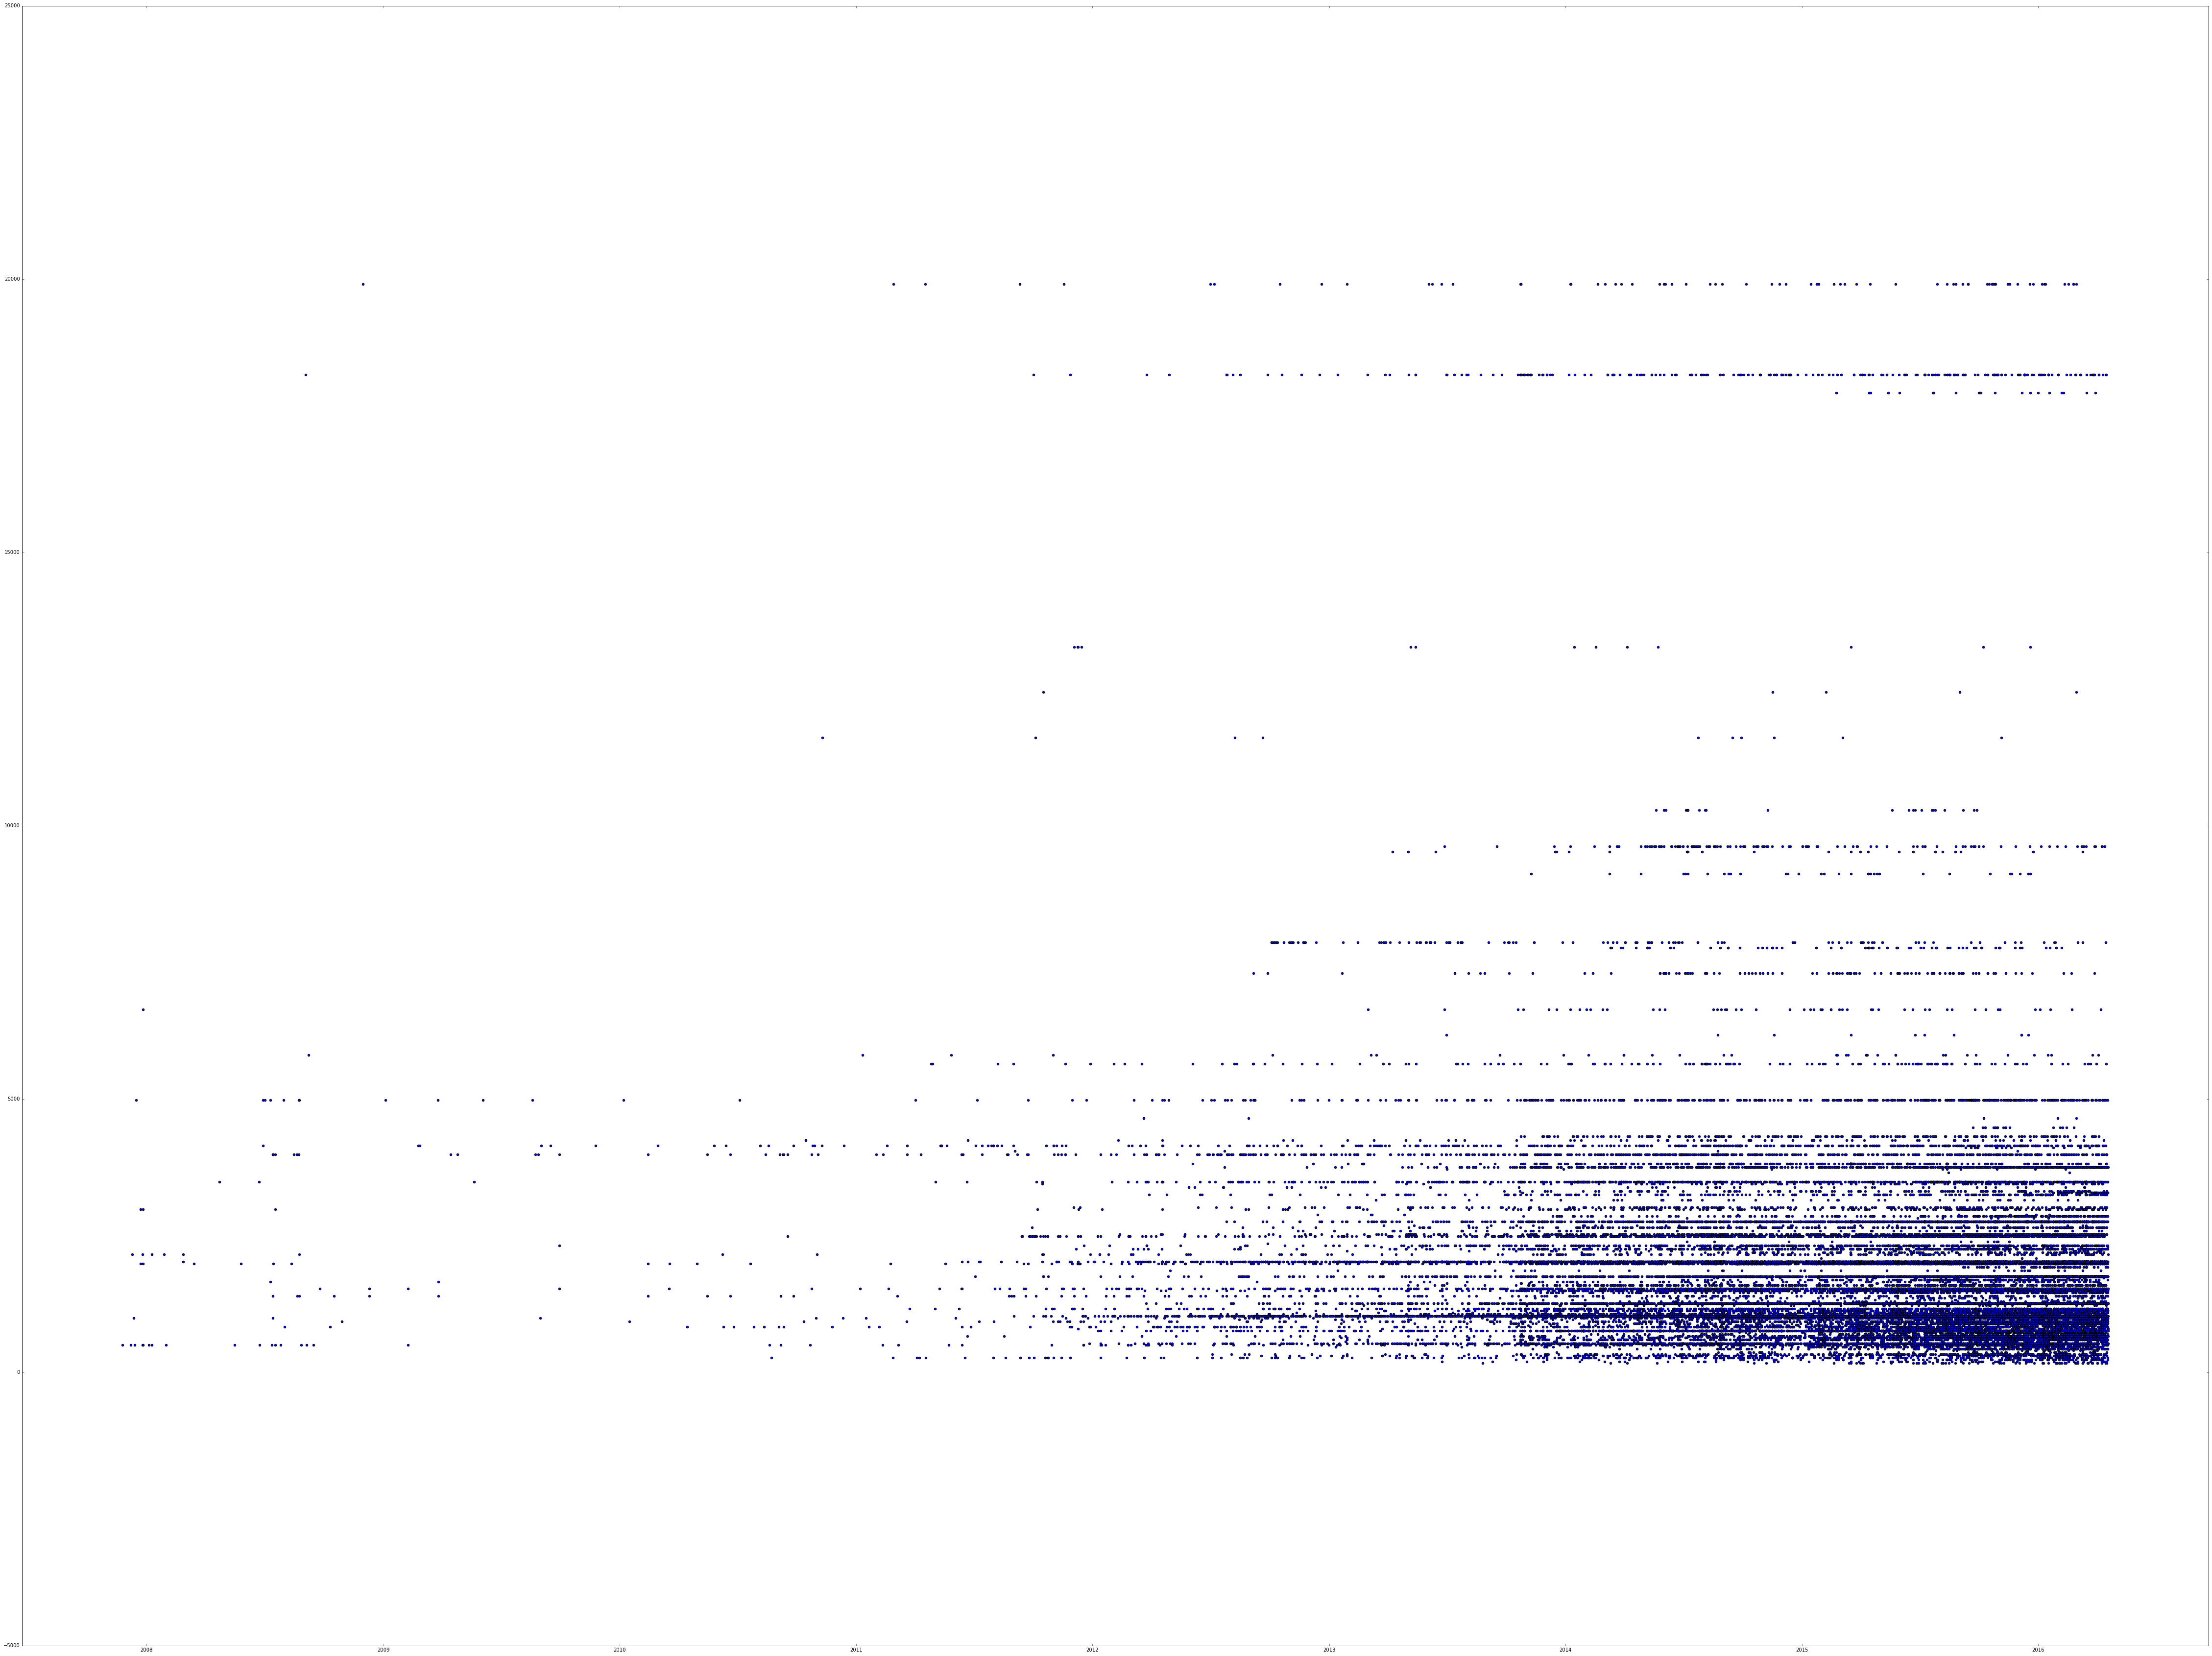

In [368]:
plt.figure(figsize=(80,60))
plt.scatter(date_check_arr.datetime64, date_check_arr.check)

Но как видно, такая картинка ничего не дала, потому что точки расположены слишком плотно :(   
Поэтому для третьего графика было решено рассчитать процентное изменение количества отзывов за каждый месяц, разделить линии ресторанов по цвету в зависимости от величины чека и посмотреть, линии какого цвета будут стремиться преимущественно к верхнему, а какие - к нижнему сегменту графика в период с 2015 г.

In [369]:
def get_percent_chnge(arr, lst):
    months = np.arange('2008-01', '2016-05', dtype='datetime64').astype('O')
    months_counts = np.core.records.fromarrays([months, np.zeros_like(months, dtype = 'i')], names = 'date, count')
    for i in arr:
        for j in months_counts:
            if i.datetime64.month==j.date.month and i.datetime64.year==j.date.year:
                j.count += 1
    base_value_index = np.nonzero(months_counts.count)[0][0]-1
    months_counts.count = np.cumsum(months_counts.count)
    change_array = np.diff(months_counts.count) / np.abs(months_counts[:-1].count)*100
    change_array[base_value_index] = 0
    change_array[np.isnan(change_array)] = 0
    change_array = np.insert(change_array, 1, 0)
    months_change = np.core.records.fromarrays([months, np.cumsum(change_array)], dtype=[('date', 'O'), ('change', '<f2')], names = 'date, change')
    lst.append(months_change)

In [370]:
percent_changes = []
for i in database['Stats']:
    get_percent_chnge(i, percent_changes)

In [379]:
database['% chnge 2008-2016'] = percent_changes

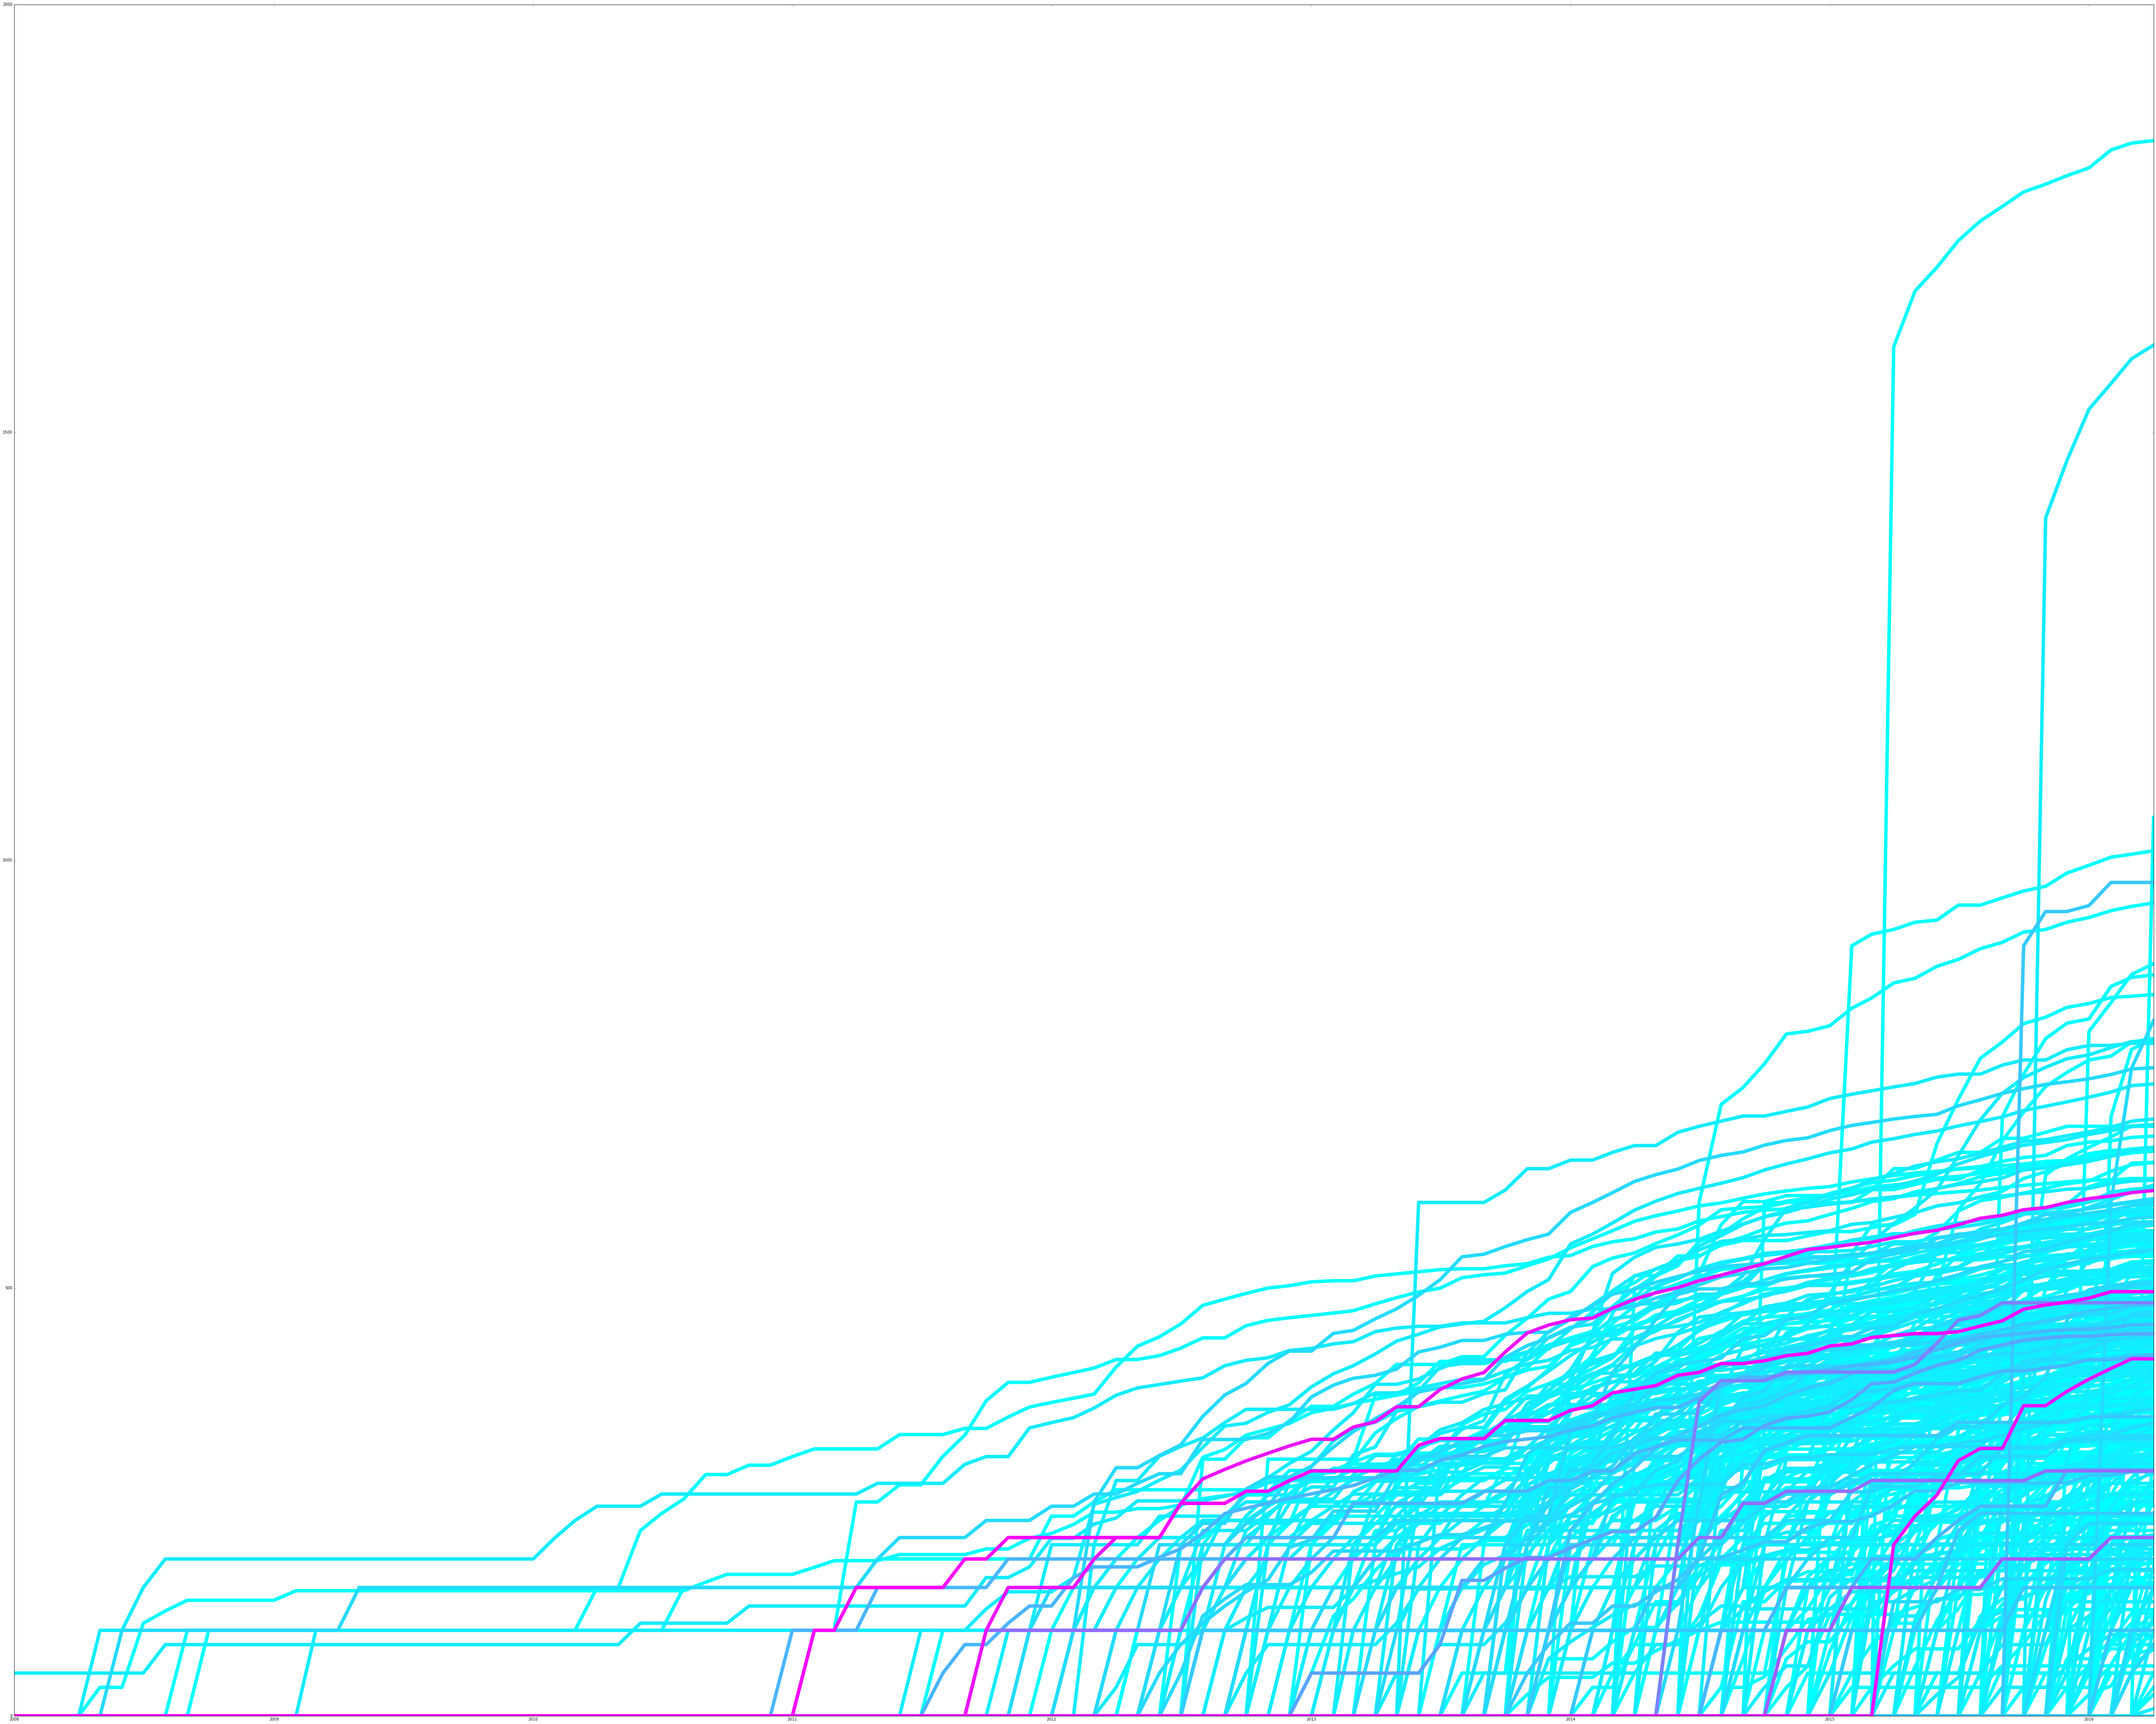

In [386]:
filters = np.linspace(database['Avg check'].min(), database['Avg check'].max()+1, 30)
filter_pairs = [tuple(p) for p in np.split(filters, 15)]
color_ids = np.linspace(0, 1, len(filter_pairs))
plt.figure(figsize=(100,80))
for f,i in enumerate(color_ids):
    x = database['% chnge 2008-2016'][(database['Avg check']>filter_pairs[f][0]) & (database['Avg check']<filter_pairs[f][1])]
    for j in x:
        plt.plot(j.date, j.change, color=plt.cm.cool(i), lw=9)

На этом графике рестораны от более дорогого чека к более дешевому меняют цвет с фиолетового на голубой. Хотя график опять очень плотный, видно, что динамика изменения количества отзывов выше для ресторанов из более бюджетных категорий, причем этот тренд наметился даже раньше 2015 г, что, возможно, объясняется спецификой ресурса tripadvisor. Есть несколько подозрительно резко набравших отзывы бюджетных ресторанов, для которых будет интересно посмотреть на рейтинг отзывов. Видно, что для большинства ресторанов наклон кривой прироста количества отзывов падает, что, в том числе, говорит о том, что люди уменьшили число походов в рестораны в принципе. Такая приближенная картинка согласуется с предположениями, выдвинутыми в начале.

В заключение нужно пояснить, что рейтинги, собранные вместе с датой каждого отзыва, не использованные в данном проекте, я собрала, чтобы воспользоваться ими в следующем проекте на R.
Спасибо за внимание :)

In [14]:
for i in database['Stats'][1000:1039]:
    plt.plot(database['Stats'][i].datetime64, database['Stats'][i].x)
    

AttributeError: 'Series' object has no attribute 'datetime64'

In [17]:
database['Stats'][1].datetime64

array([datetime.date(2013, 8, 26), datetime.date(2014, 3, 11),
       datetime.date(2014, 4, 6), datetime.date(2014, 5, 22),
       datetime.date(2014, 10, 19), datetime.date(2014, 11, 7),
       datetime.date(2015, 2, 19), datetime.date(2015, 3, 18),
       datetime.date(2015, 8, 16), datetime.date(2015, 12, 3),
       datetime.date(2016, 1, 30)], dtype=object)

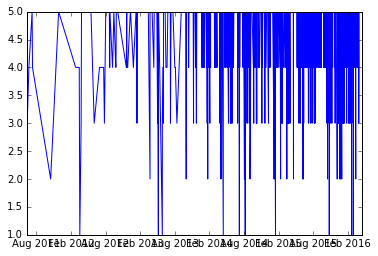

In [41]:
plt.plot(database['Stats'][1015].datetime64, database['Stats'][1015].x)

In [21]:
df2 = database.set_index(['Name'])

In [42]:
database[5:(5+2)]

Name  Avg check  \
5           Пян-се        166   
6  Caffe del Parco        199   

                                               Stats 1st revw date  
5  [[2015-03-15, 4.0], [2015-03-26, 4.0], [2015-0...    2015-03-15  
6  [[2014-06-08, 5.0], [2014-07-25, 4.0], [2014-1...    2014-06-08

In [43]:
df = pd.DataFrame([[1, 2, 3], 
                   [4, 5, 6], 
                   [7, 8, 9], 
                   [10, 11, 12], 
                   [13, 14, 15], 
                   [16, 17, 18], 
                   [19, 20, 21]])

In [46]:
df[4:(4+1)]

0   1   2
4  13  14  15

In [45]:
database

Name  Avg check  \
0                            Дэйли Кофе      165.5   
1                      Aromi la bottega      165.5   
2                               БухУчёт      165.5   
3                              Ватрушка      165.5   
4                            Koupes Bar      166.0   
5                                Пян-се      166.0   
6                       Caffe del Parco      199.0   
7                            Urban Cafe      199.0   
8                                Пян-се      199.0   
9                           ПитерБургер      199.0   
10                            Эль Асадо      199.0   
11                         Помидорка РП      199.0   
12                           ПАСТА ТАЙМ      232.0   
13                           Мистер Пит      232.0   
14                               НаВоке      232.0   
15                  Траттория "БУОНИНИ"      232.0   
16                          Гриль&Гирос      232.5   
17                                Варка      232.5   
18    Coffee and the City на Бауманской      232.5   
19                  Coffee and the City      232.5   
20                     Джелатерия AMORE      232.5   
21                     Ресторан Санремо      232.5   
22                            Porosello      232.5   
23                           Калина Бар      265.0   
24                              Бризоль      265.0   
25                                Океан      265.0   
26                      Кафе Арифметика      265.5   
27                           Коммуналка      265.5   
28     Свободное пространство Циферблат      265.5   
29                           Урбан Кафе      265.5   
...                                 ...        ...   
1004     Арт- Ресторация Степа Лиходеев     4313.5   
1005                         Honey Life     4313.5   
1006                   La Bella Societa     4479.5   
1007                  Ресторан Ай Фиори     4645.0   
1008                Ресторан "От Кутюр"     4645.5   
1009                     Brasserie Мост     4977.0   
1010    Ресторан "Белое Солнце Пустыни"     4977.0   
1011                       Храм Дракона     4977.0   
1012                          Темпл Бар     4977.0   
1013             Balzi Rossi Restaurant     4977.0   
1014                 Караоке клуб Дуэты     4977.0   
1015                 Октябрь Event Hall     4977.0   
1016                Ресторан "Павильон"     5640.5   
1017                       Балчуг Гриль     5806.5   
1018                          Cipollino     6171.5   
1019                           Бельэтаж     6636.0   
1020                             Фреско     6636.0   
1021       Ресторан-бар "Консерватория"     7299.5   
1022                           Оптимист     7764.5   
1023                        Pane & Olio     7864.0   
1024                            Буйабес     9124.5   
1025                               Пеши     9523.0   
1026                          Бар Крыша     9622.0   
1027                          Royal Bar    10286.0   
1028                         Тинто Фино    11613.0   
1029                  Ресторан Fabrique    12442.5   
1030                             Мисато    13272.0   
1031              Greene King Pub&Roast    17917.5   
1032                       Рыбный базар    18249.5   
1033                                Яръ    19908.5   

                                                  Stats 1st revw date  
0     [[2016-01-29, 5.0], [2016-02-03, 5.0], [2016-0...    2016-01-29  
1     [[2013-08-26, 5.0], [2014-03-11, 5.0], [2014-0...    2013-08-26  
2     [[2016-01-09, 5.0], [2016-03-02, 5.0], [2016-0...    2016-01-09  
3     [[2016-01-29, 5.0], [2016-02-02, 5.0], [2016-0...    2016-01-29  
4     [[2015-07-22, 5.0], [2015-09-07, 5.0], [2015-0...    2015-07-22  
5     [[2015-03-15, 4.0], [2015-03-26, 4.0], [2015-0...    2015-03-15  
6     [[2014-06-08, 5.0], [2014-07-25, 4.0], [2014-1...    2014-06-08  
7                                   [[2015-10-05, 5.0]]    2015-10-05  
8     [[2015-09-04, 5.0], [2015-09-22,